In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency

/opt/anaconda3/envs/churn_project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dataset
df = pd.read_csv(r'/Users/user/Downloads/Customer Churn.csv')

In [3]:
# Display the dataset information
print(df.info())

# Data Cleaning and Preprocessing

# Check for missing values
print("Missing values in each column:\n", df.isnull().sum())

# Display the first few rows of the cleaned and preprocessed dataset
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call  Failure            3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription  Length     3150 non-null   int64  
 3   Charge  Amount           3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn                    3150 non-null   int64  
dtypes: float64(1), int64(13)

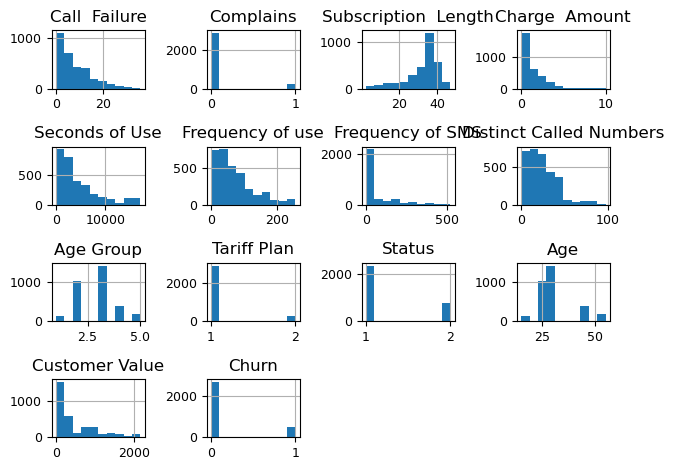

In [4]:
# Plot histogram for all columns
df.hist(xlabelsize = 9, ylabelsize = 9)
plt.tight_layout()
plt.show()

In [5]:
# Summary statistics of the dataset
print(df.describe())

       Call  Failure    Complains  Subscription  Length  Charge  Amount  \
count    3150.000000  3150.000000           3150.000000     3150.000000   
mean        7.627937     0.076508             32.541905        0.942857   
std         7.263886     0.265851              8.573482        1.521072   
min         0.000000     0.000000              3.000000        0.000000   
25%         1.000000     0.000000             30.000000        0.000000   
50%         6.000000     0.000000             35.000000        0.000000   
75%        12.000000     0.000000             38.000000        1.000000   
max        36.000000     1.000000             47.000000       10.000000   

       Seconds of Use  Frequency of use  Frequency of SMS  \
count     3150.000000       3150.000000       3150.000000   
mean      4472.459683         69.460635         73.174921   
std       4197.908687         57.413308        112.237560   
min          0.000000          0.000000          0.000000   
25%       1391.2500

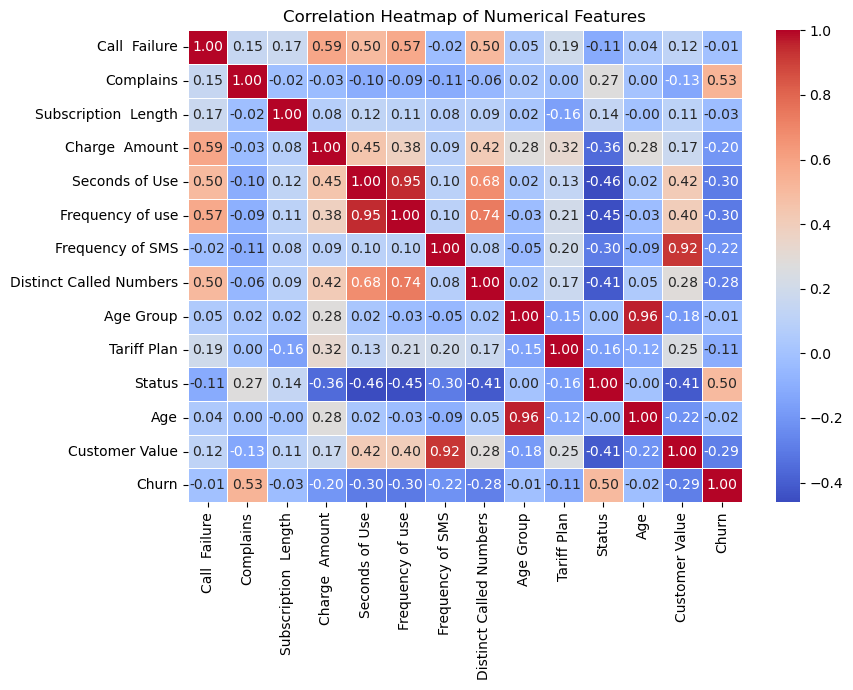

In [6]:
plt.figure(figsize=(9, 7))
correlation_matrix = df.corr(numeric_only=True)

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

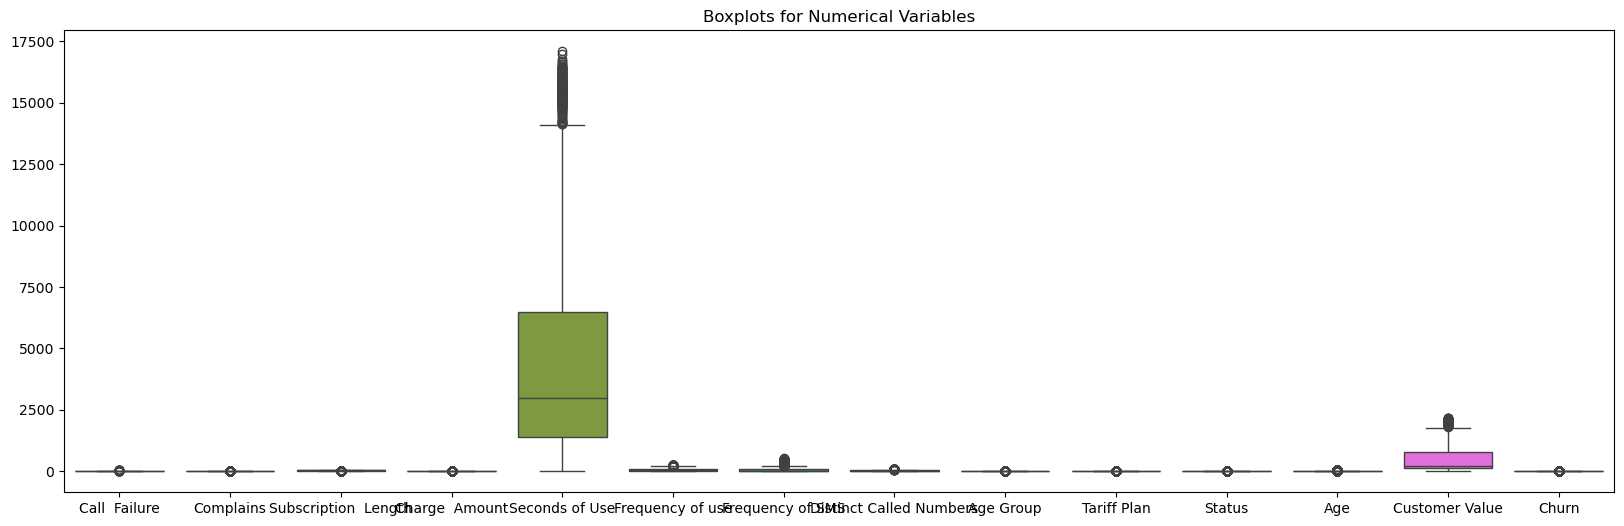

In [7]:
# Create boxplots for all features
plt.figure(figsize=(20,6))
sns.boxplot(data=df)
plt.title('Boxplots for Numerical Variables')
plt.show()

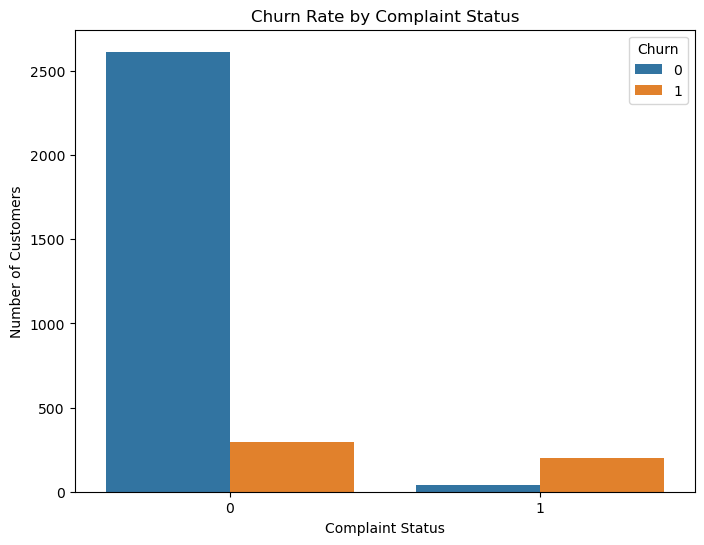

In [8]:
# Create a bar plot to visualize the churn rate for customers who complained vs those who did not
plt.figure(figsize=(8, 6))
sns.countplot(x = 'Complains', hue = 'Churn', data = df)
plt.title('Churn Rate by Complaint Status')
plt.xlabel('Complaint Status')
plt.ylabel('Number of Customers')
plt.legend(title='Churn')
plt.show()

In [9]:
# Calculate churn rates for customers who complained vs those who did not
complaint_churn_rate = df[df['Complains'] == 1]['Churn'].mean()
no_complaint_churn_rate = df[df['Complains'] == 0]['Churn'].mean()

print(f"Churn rate for customers who complained: {complaint_churn_rate:.2f}")
print(f"Churn rate for customers who did not complain: {no_complaint_churn_rate:.2f}")

# Perform a chi-square test to see if there is a significant association between Churn and Complaint
contingency_table = pd.crosstab(df['Churn'], df['Complains'])
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-square statistics: {chi2:.2f}")
print(f"P-value: {p:.2f}")

if p < 0.05:
    print("There is a significant association between Churn and Complaint (p < 0.05).")
else:
    print("There is no significant association between Churn and Complaint (p >= 0.05).")

Churn rate for customers who complained: 0.83
Churn rate for customers who did not complain: 0.10
Chi-square statistics: 886.21
P-value: 0.00
There is a significant association between Churn and Complaint (p < 0.05).


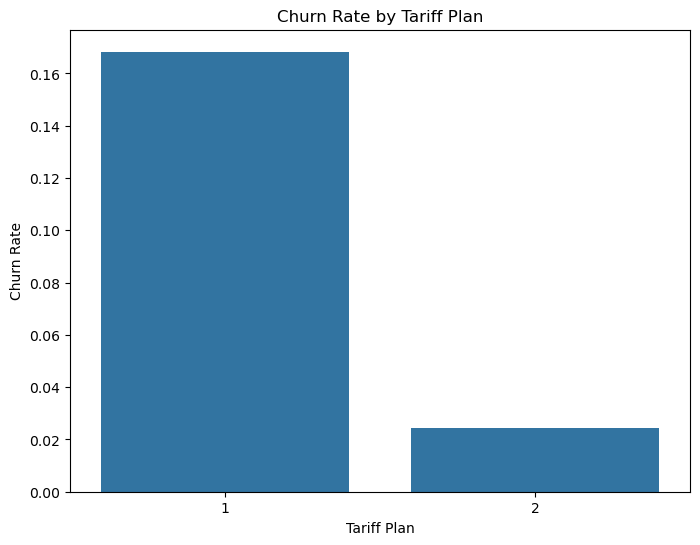

In [10]:
# Impact of tariff Plan on churn
plt.figure(figsize = (8, 6))
sns.barplot(x = 'Tariff Plan', y = 'Churn', data = df, errorbar = None)
plt.title('Churn Rate by Tariff Plan')
plt.xlabel('Tariff Plan')
plt.ylabel('Churn Rate')
plt.show()

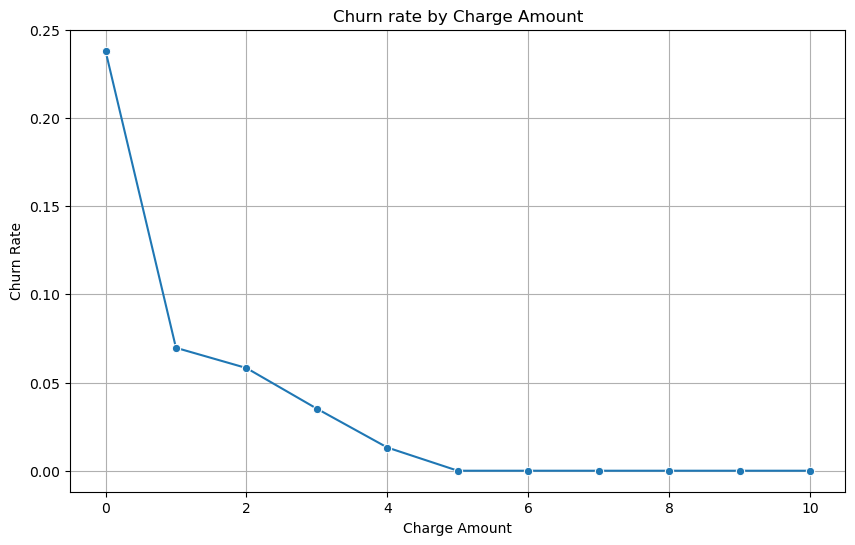

In [11]:
# Calculate churn rate by charge amount
churn_rate_by_charge_amount = df.groupby('Charge  Amount')['Churn'].mean().reset_index()

# Plotting a line chart
plt.figure(figsize = (10, 6))
sns.lineplot(x = 'Charge  Amount', y = 'Churn', data = churn_rate_by_charge_amount, marker = 'o')
plt.title('Churn rate by Charge Amount')
plt.xlabel('Charge Amount')
plt.ylabel('Churn Rate')
plt.grid(True)
plt.show()

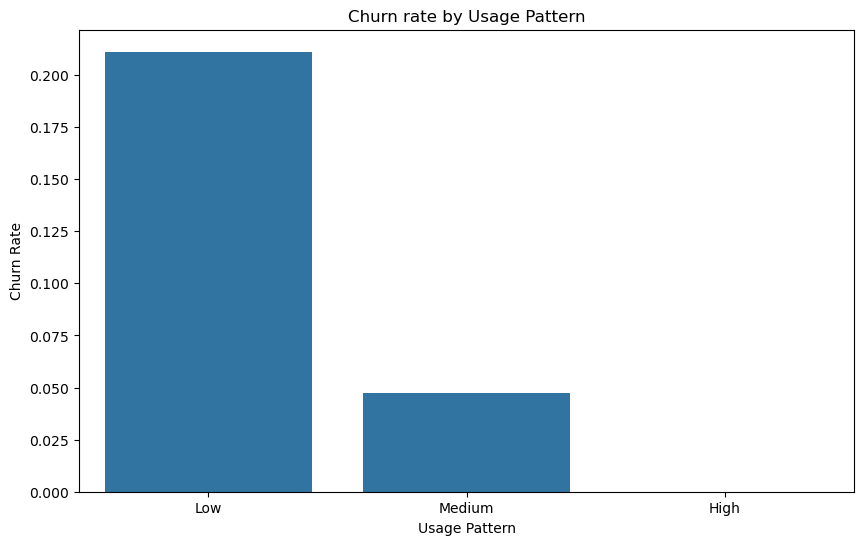

In [12]:
# Customer segmentation based on usage patterns
df['Usage Pattern'] = pd.cut(df['Frequency of use'], bins = 3, labels = ['Low', 'Medium', 'High'])
plt.figure(figsize = (10, 6))
sns.barplot(x = 'Usage Pattern', y = 'Churn', data = df, errorbar = None)
plt.title('Churn rate by Usage Pattern')
plt.xlabel('Usage Pattern')
plt.ylabel('Churn Rate')
plt.show()

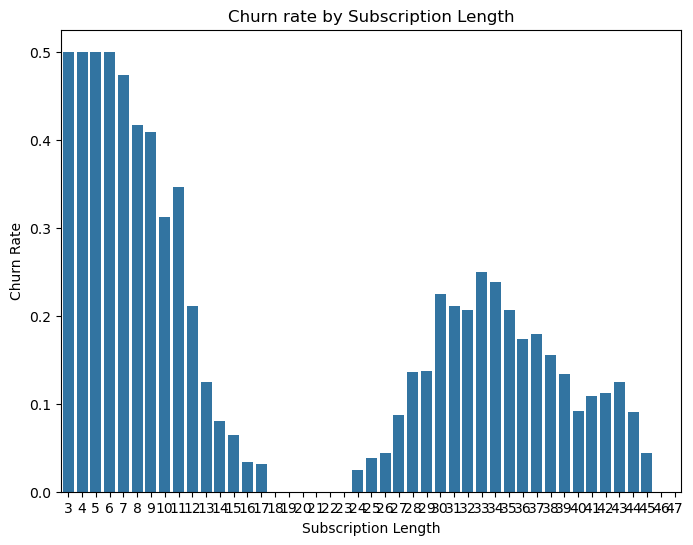

In [13]:
# Impact of Subscription Length on Churn
plt.figure(figsize = (8, 6))
sns.barplot(x = 'Subscription  Length', y = 'Churn', data = df, errorbar = None)
plt.title('Churn rate by Subscription Length')
plt.xlabel('Subscription Length')
plt.ylabel('Churn Rate')
plt.show()

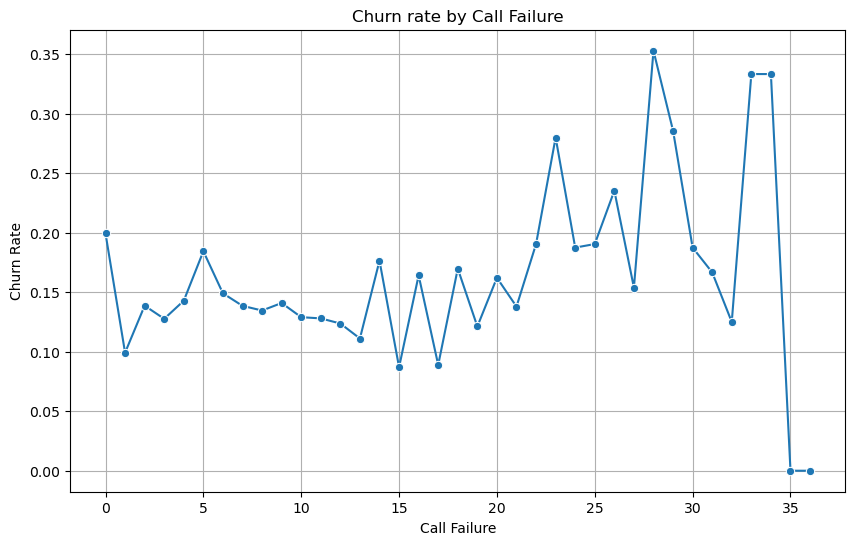

In [14]:
#Calculate the churn rate for each unique Call Failure value
churn_rate_by_call_failure = df.groupby('Call  Failure')['Churn'].mean().reset_index()

# Plotting a line chart
plt.figure(figsize = (10, 6))
sns.lineplot(x = 'Call  Failure', y = 'Churn', data = churn_rate_by_call_failure, marker = 'o')
plt.title('Churn rate by Call Failure')
plt.xlabel('Call Failure')
plt.ylabel('Churn Rate')
plt.grid(True)
plt.show()

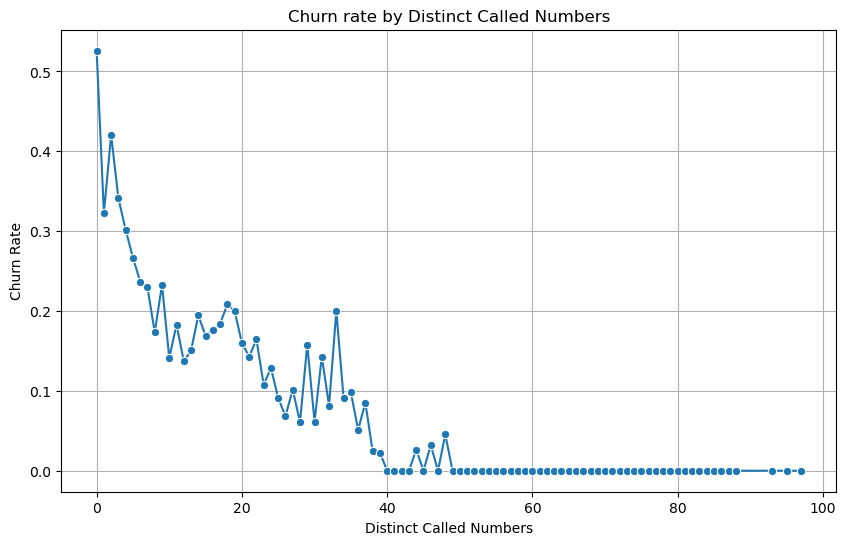

In [15]:
#Calculate the churn rate for each unique Distinct Called Numbers value
churn_rate_by_distinct_called_numbers = df.groupby('Distinct Called Numbers')['Churn'].mean().reset_index()

# Plotting a line chart
plt.figure(figsize = (10, 6))
sns.lineplot(x = 'Distinct Called Numbers', y = 'Churn', data = churn_rate_by_distinct_called_numbers, marker = 'o')
plt.title('Churn rate by Distinct Called Numbers')
plt.xlabel('Distinct Called Numbers')
plt.ylabel('Churn Rate')
plt.grid(True)
plt.show()

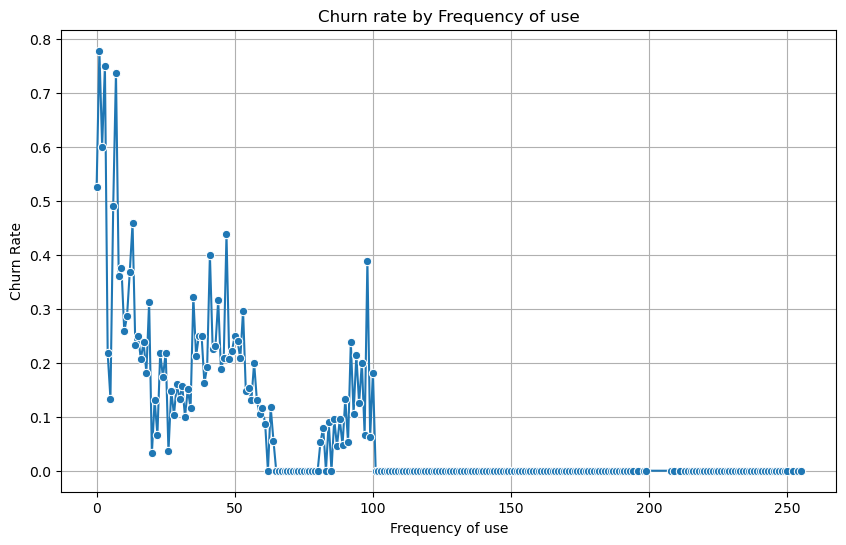

In [16]:
#Calculate the churn rate for each unique Frequency of use value
churn_rate_by_frequency_of_use = df.groupby('Frequency of use')['Churn'].mean().reset_index()

# Plotting a line chart
plt.figure(figsize = (10, 6))
sns.lineplot(x = 'Frequency of use', y = 'Churn', data = churn_rate_by_frequency_of_use, marker = 'o')
plt.title('Churn rate by Frequency of use')
plt.xlabel('Frequency of use')
plt.ylabel('Churn Rate')
plt.grid(True)
plt.show()

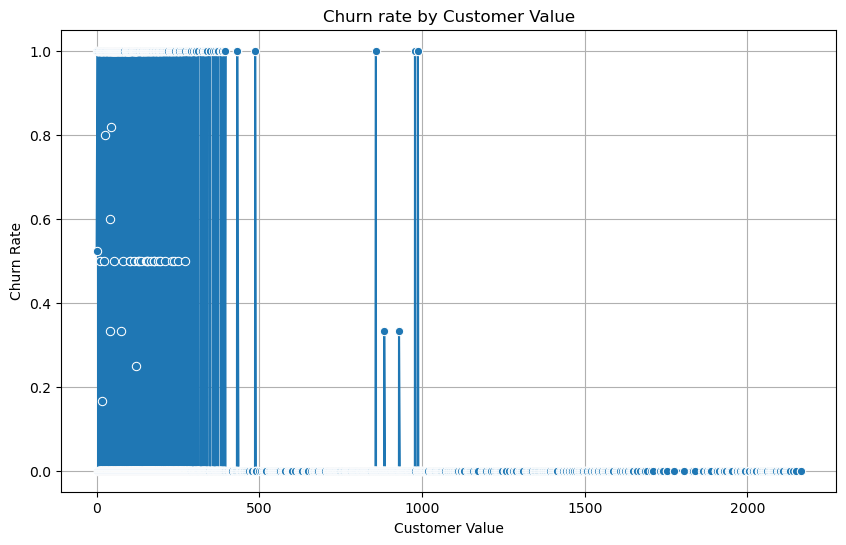

In [17]:
#Calculate the churn rate for each unique Customer Value value
churn_rate_by_customer_Value = df.groupby('Customer Value')['Churn'].mean().reset_index()

# Plotting a line chart
plt.figure(figsize = (10, 6))
sns.lineplot(x = 'Customer Value', y = 'Churn', data = churn_rate_by_customer_Value, marker = 'o')
plt.title('Churn rate by Customer Value')
plt.xlabel('Customer Value')
plt.ylabel('Churn Rate')
plt.grid(True)
plt.show()

In [18]:
if "Usage Pattern" in df.columns:
    df.drop(columns=["Usage Pattern"], inplace=True)

# Selecting features and target variable
X = df.drop(columns=["Churn"])

# Convert all columns to numeric, coercing errors to handle unexpected values
X = X.apply(pd.to_numeric, errors='coerce')

y = df["Churn"]

# Feature Selection with RFE
model_for_rfe = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=model_for_rfe, n_features_to_select=10)
X_rfe = rfe.fit_transform(X, y)
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features.tolist())

# Splitting the dataset into training and testing sets (80% train, 20% test)
X_selected = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Standardizing the features (important for models like Logistic Regression and KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Checking the shape of the train and test sets
X_train_scaled.shape, X_test_scaled.shape

# Addressing class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

Selected Features: ['Call  Failure', 'Complains', 'Subscription  Length', 'Seconds of Use', 'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers', 'Status', 'Age', 'Customer Value']


In [19]:
baseline_models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42)
}

baseline_results = {}

for name, model in baseline_models.items():
    if name == 'Random Forest':
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_balanced, y_train_balanced)
        y_pred = model.predict(X_test_scaled)
    
    baseline_results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred)
    }

print("Baseline Model Performance:\n")
print(pd.DataFrame(baseline_results))

Baseline Model Performance:

           Logistic Regression       KNN  Random Forest
Accuracy              0.847619  0.946032       0.963492
Precision             0.508772  0.764228       0.895833
Recall                0.878788  0.949495       0.868687
F1 Score              0.644444  0.846847       0.882051
AUC                   0.860298  0.947441       0.924927


In [20]:
#Hyperparameter tuning with RandomizedSearchCV
param_grids = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10]},
    'KNN': {'n_neighbors': [3, 5, 7, 9]},
    'Random Forest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
}

tuned_models = {}
for name, model in baseline_models.items():
    search = RandomizedSearchCV(model, param_grids[name], cv=3, scoring='f1', n_iter=4, random_state=42)
    
    if name == 'Random Forest':
        search.fit(X_train, y_train)
    else:
        search.fit(X_train_balanced, y_train_balanced)
    
    tuned_models[name] = search.best_estimator_

#Evaluation of tuned models
tuned_results = {}
for name, model in tuned_models.items():
    if name == 'Random Forest':
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test_scaled)
    
    tuned_results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred)
    }

print("\nTuned Model Performance:\n")
print(pd.DataFrame(tuned_results))


Tuned Model Performance:

           Logistic Regression       KNN  Random Forest
Accuracy              0.847619  0.950794       0.963492
Precision             0.508772  0.788136       0.904255
Recall                0.878788  0.939394       0.858586
F1 Score              0.644444  0.857143       0.880829
AUC                   0.860298  0.946156       0.920818


In [21]:
#Feature importance from tuned Random Forest
importances = tuned_models['Random Forest'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Important Features (Random Forest):\n")
print(feature_importance_df.head(10))


Top 10 Important Features (Random Forest):

                   Feature  Importance
1                Complains    0.207148
7                   Status    0.129498
3           Seconds of Use    0.128808
2     Subscription  Length    0.117857
4         Frequency of use    0.099695
9           Customer Value    0.083995
6  Distinct Called Numbers    0.076735
0            Call  Failure    0.062594
5         Frequency of SMS    0.049871
8                      Age    0.043800
